In [24]:
import paste2.PASTE2 as pst
from paste2.model_selection import select_overlap_fraction
from paste2.projection import partial_stack_slices_pairwise

In [2]:
import os
from pathlib import Path

import scanpy as sc
import numpy as np

In [3]:
data_dir = '/data/spatial_transcriptomics/spaceranger_outputs/breast/'
fps = [os.path.join(data_dir, fp) for fp in os.listdir(data_dir) if '206B1_U' in fp]
fps

['/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U2',
 '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U3',
 '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U4',
 '/data/spatial_transcriptomics/spaceranger_outputs/breast/BR_206B1_U5']

In [4]:
def preprocess_adata(a):
    # save raw counts for future use
    a.layers['counts'] = a.X.copy()

    # stadard ST expression normalization
    sc.pp.normalize_total(a, inplace=True)
    sc.pp.log1p(a)

    # identifying most variable genes
    sc.pp.highly_variable_genes(a, flavor="seurat", n_top_genes=3000)
    a.raw = a
    a = a[:, a.var.highly_variable]
    sc.pp.scale(a)

    # getting some initial umap and clustering results
    # NOTE: may not be the most reliable given we didn't filter for only most variable genes
    sc.pp.pca(a)
    sc.pp.neighbors(a)
    sc.tl.umap(a)
    sc.tl.leiden(a, key_added="clusters")
    
    return a

In [5]:
# !conda install -c conda-forge leidenalg -y

In [6]:
sid_to_adata = {}
for fp in fps:
    sid = fp.split('/')[-1]
    a = sc.read_visium(fp)
    a.var_names_make_unique()
    a = preprocess_adata(a)
    sid_to_adata[sid] = a
sid_to_adata.keys()

/data/estorrs/miniconda3/envs/paste2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/paste2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/estorrs/miniconda3/envs/paste2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/paste2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/data/estorrs/miniconda3/envs/paste2/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_

dict_keys(['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5'])

In [7]:
order = sorted(sid_to_adata.keys()) # order of slices
order

['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5']

In [8]:
sets = [set(a.var.index) for a in sid_to_adata.values()]
common = sorted(set.intersection(*sets))
len(common)

609

In [9]:
sid_to_count_adata = {}
for sid, a in sid_to_adata.items():
    a.X = a.layers['counts']
    a = a[:, common]
    sid_to_count_adata[sid] = a

In [10]:
sid_to_count_adata.keys()

dict_keys(['BR_206B1_U2', 'BR_206B1_U3', 'BR_206B1_U4', 'BR_206B1_U5'])

In [11]:
a = next(iter(sid_to_count_adata.values()))
a

View of AnnData object with n_obs × n_vars = 3949 × 609
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [12]:
def get_spot_rgb(img, r, c, radius):
    r1, r2 = r - radius, r + radius
    c1, c2 = c - radius, c + radius
    crop = img[r1:r2, c1:c2]
    return crop.mean(axis=(0, 1))

def add_spot_rgb(a):
    he = next(iter(a.uns['spatial'].values()))['images']['lowres']
    scale = next(iter(a.uns['spatial'].values()))['scalefactors']['tissue_lowres_scalef']
    diameter = int(next(iter(a.uns['spatial'].values()))['scalefactors']['spot_diameter_fullres'] * scale)
    coords = (a.obsm['spatial'] * scale).astype(np.int32)
    
    rgb_matrix = np.zeros((a.shape[0], 3))
    for i in range(a.shape[0]):
        c, r = coords[i]
        rgb_matrix[i] = get_spot_rgb(he, r, c, diameter // 4)
        
    a.obsm['rgb'] = rgb_matrix
    
    return a

In [13]:
for k, a in sid_to_count_adata.items():
    sid_to_count_adata[k] = add_spot_rgb(a)

In [46]:
def align_slice_pair(a1, a2, max_iter=100):
    s = select_overlap_fraction(a1, a2, max_iter=max_iter)
    return pst.partial_pairwise_align_histology(a1, a2, max_iter=max_iter, s=s)

def align_slices(adatas, max_iter=100):
    alignments = []
    for i in range(len(adatas) - 1):
        print(i)
        a1, a2 = adatas[i], adatas[i + 1]
        alignments.append(align_slice_pair(a1, a2, max_iter=max_iter))
    return partial_stack_slices_pairwise(adatas, alignments)
    

In [47]:
registered = align_slices([sid_to_count_adata[k] for k in order])

0
PASTE2 model selection procedure.
Starting GLM-PCA...
Iteration: 0 | deviance=1.3489E+7
Iteration: 1 | deviance=1.2309E+7
Iteration: 2 | deviance=5.3582E+6
Iteration: 3 | deviance=4.1710E+6
Iteration: 4 | deviance=3.8072E+6
Iteration: 5 | deviance=3.6281E+6
Iteration: 6 | deviance=3.5133E+6
Iteration: 7 | deviance=3.4361E+6
Iteration: 8 | deviance=3.3820E+6
Iteration: 9 | deviance=3.3422E+6
Iteration: 10 | deviance=3.3116E+6
Iteration: 11 | deviance=3.2874E+6
Iteration: 12 | deviance=3.2677E+6
Iteration: 13 | deviance=3.2513E+6
Iteration: 14 | deviance=3.2375E+6
Iteration: 15 | deviance=3.2256E+6
Iteration: 16 | deviance=3.2152E+6
Iteration: 17 | deviance=3.2061E+6
Iteration: 18 | deviance=3.1980E+6
Iteration: 19 | deviance=3.1907E+6
Iteration: 20 | deviance=3.1841E+6
Iteration: 21 | deviance=3.1782E+6
Iteration: 22 | deviance=3.1728E+6
Iteration: 23 | deviance=3.1678E+6
Iteration: 24 | deviance=3.1632E+6
Iteration: 25 | deviance=3.1589E+6
Iteration: 26 | deviance=3.1550E+6
Iteration

Starting GLM-PCA...
GLM-PCA finished.
2
PASTE2 model selection procedure.
Starting GLM-PCA...
Iteration: 0 | deviance=1.3710E+7
Iteration: 1 | deviance=1.2228E+7
Iteration: 2 | deviance=5.3123E+6
Iteration: 3 | deviance=4.0242E+6
Iteration: 4 | deviance=3.6928E+6
Iteration: 5 | deviance=3.5246E+6
Iteration: 6 | deviance=3.4183E+6
Iteration: 7 | deviance=3.3446E+6
Iteration: 8 | deviance=3.2910E+6
Iteration: 9 | deviance=3.2506E+6
Iteration: 10 | deviance=3.2191E+6
Iteration: 11 | deviance=3.1939E+6
Iteration: 12 | deviance=3.1731E+6
Iteration: 13 | deviance=3.1557E+6
Iteration: 14 | deviance=3.1409E+6
Iteration: 15 | deviance=3.1282E+6
Iteration: 16 | deviance=3.1171E+6
Iteration: 17 | deviance=3.1074E+6
Iteration: 18 | deviance=3.0987E+6
Iteration: 19 | deviance=3.0910E+6
Iteration: 20 | deviance=3.0840E+6
Iteration: 21 | deviance=3.0777E+6
Iteration: 22 | deviance=3.0719E+6
Iteration: 23 | deviance=3.0667E+6
Iteration: 24 | deviance=3.0618E+6
Iteration: 25 | deviance=3.0574E+6
Iterat

In [48]:
out_dir = '/data/estorrs/paste2/results/HT206B1/aligned'
Path(out_dir).mkdir(parents=True, exist_ok=True)
for sid, a in zip(order, registered):
    a.write_h5ad(os.path.join(out_dir, f'{sid}.h5ad'))

In [49]:
registered

[AnnData object with n_obs × n_vars = 3949 × 609
     obs: 'in_tissue', 'array_row', 'array_col', 'clusters'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'spatial', 'X_pca', 'X_umap', 'rgb'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 4311 × 609
     obs: 'in_tissue', 'array_row', 'array_col', 'clusters'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'spatial', 'X_pca', 'X_umap', 'rgb'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 4132 × 609
     obs: 'in_tissue', 'array_row', 'array_col', 'clusters'
     var: 'gene_i

In [17]:
s = select_overlap_fraction(sid_to_count_adata[order[0]], sid_to_count_adata[order[1]], max_iter=50, )

PASTE2 model selection procedure.
Starting GLM-PCA...
Iteration: 0 | deviance=1.3489E+7
Iteration: 1 | deviance=1.2302E+7
Iteration: 2 | deviance=5.4055E+6
Iteration: 3 | deviance=4.2139E+6
Iteration: 4 | deviance=3.8228E+6
GLM-PCA finished.
Running PASTE2 with s = 0.99...
Running PASTE2 with s = 0.95...
Running PASTE2 with s = 0.9...
Running PASTE2 with s = 0.85...
Running PASTE2 with s = 0.8...
Running PASTE2 with s = 0.75...
Running PASTE2 with s = 0.7...
Running PASTE2 with s = 0.65...
Running PASTE2 with s = 0.6...
Running PASTE2 with s = 0.55...
Running PASTE2 with s = 0.5...
Running PASTE2 with s = 0.45...
Running PASTE2 with s = 0.4...
Running PASTE2 with s = 0.35...
Running PASTE2 with s = 0.3...
Running PASTE2 with s = 0.25...
Running PASTE2 with s = 0.2...
Running PASTE2 with s = 0.15...
Running PASTE2 with s = 0.1...
Running PASTE2 with s = 0.05...
Estimation of overlap percentage is 0.8


In [19]:
s = out

In [20]:
out = pst.partial_pairwise_align_histology(
    sid_to_count_adata[order[0]], sid_to_count_adata[order[1]], max_iter=5, s=s)

PASTE2 starts...
Starting GLM-PCA...
GLM-PCA finished.


In [22]:
out.shape

(3949, 4311)

In [23]:
out.sum()

0.8000000000000044

In [26]:
result = partial_stack_slices_pairwise([sid_to_count_adata[order[0]], sid_to_count_adata[order[1]]],
                             [out])

In [27]:
result

[AnnData object with n_obs × n_vars = 3949 × 609
     obs: 'in_tissue', 'array_row', 'array_col', 'clusters'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'spatial', 'X_pca', 'X_umap', 'rgb'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 4311 × 609
     obs: 'in_tissue', 'array_row', 'array_col', 'clusters'
     var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
     obsm: 'spatial', 'X_pca', 'X_umap', 'rgb'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivities']

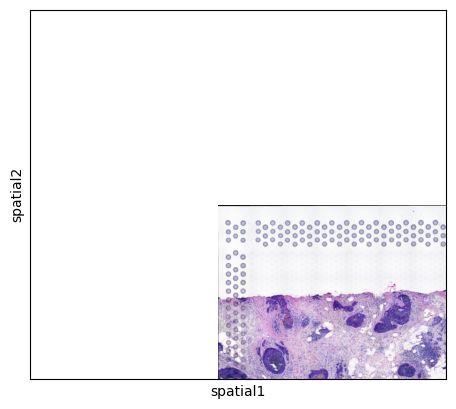

In [28]:
sc.pl.spatial(result[0])

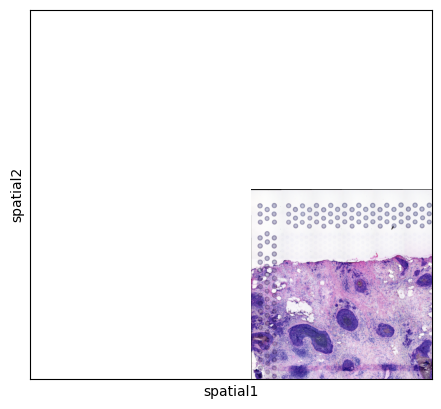

In [29]:
sc.pl.spatial(result[1])

In [31]:
result[0].obsm['spatial']

array([[-7356.27988706, -7003.90388546],
       [ 3460.72011294,  3661.09611454],
       [-6704.27988706, -3651.90388546],
       ...,
       [ 2367.72011294, -5650.90388546],
       [ 8419.72011294, -3919.90388546],
       [-5838.27988706, -2659.90388546]])

In [32]:
result[1].obsm['spatial']

array([[-9271.7558233 , -5932.2673776 ],
       [ 1524.9735582 ,  4751.22852321],
       [-8624.49423966, -2579.15457867],
       ...,
       [  449.91235449, -4561.62525038],
       [ 6497.94061972, -2820.27057572],
       [-7761.19346623, -1585.67545226]])

In [34]:
import matplotlib.pyplot as plt

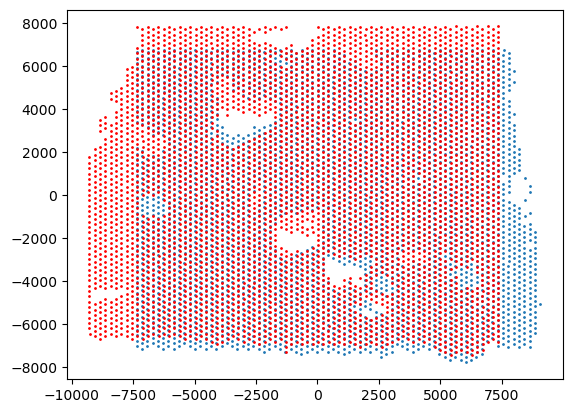

In [41]:
plt.scatter(result[0].obsm['spatial'][:, 0], result[0].obsm['spatial'][:, 1], s=1)
plt.scatter(result[1].obsm['spatial'][:, 0], result[1].obsm['spatial'][:, 1], s=1, c='red')

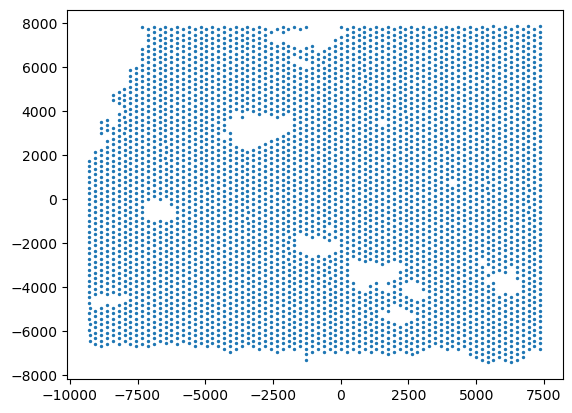

In [39]:
plt.scatter(result[1].obsm['spatial'][:, 0], result[1].obsm['spatial'][:, 1], s=2)

In [15]:
out = select_overlap_fraction(sid_to_count_adata[order[0]], sid_to_count_adata[order[1]], max_iter=5, )

PASTE2 model selection procedure.
Starting GLM-PCA...
Iteration: 0 | deviance=1.3489E+7


KeyboardInterrupt: 

In [ ]:
pst.partial_pairwise_align()